# Сервис аренды самокатов

Задача проверить гипотезы:
1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. 
2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
3 Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import json
import re
from scipy.stats import ttest_ind
import scipy.stats as stats
from scipy.stats import ttest_1samp
from math import factorial

---------------------------------------------------------------------------------------------------------------------------

# Загрузка данных

In [2]:
# Загрузка датафрейма

users = pd.read_csv("/datasets/users_go.csv")

rides = pd.read_csv("/datasets/rides_go.csv", parse_dates=['date'])

subscriptions = pd.read_csv("/datasets/subscriptions_go.csv")


In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Выводы по разделу:
Данных достаточно, нужно проверить дубликаты и выбросы, перевести в формат даты столбец date, выделить из даты месяц.

---------------------------------------------------------------------------------------------------------------------------

# Предобработка данных

In [7]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [8]:
# выделим месяц в отдельный столбец
rides['month']=pd.DatetimeIndex(rides['date']).month
rides['month']

0         1
1         1
2         4
3         8
4         8
         ..
18063    11
18064    11
18065    11
18066    11
18067    12
Name: month, Length: 18068, dtype: int64

В таблице rides пропусков нет

In [9]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [10]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Пропусков в таблицах не вижу

In [11]:
# ищем полные дубли

In [12]:
print(users.shape[0])
print(users.duplicated(subset=['user_id', 'city', 'subscription_type', 'name']).sum())

print(users[users.duplicated(subset=['user_id', 'city', 'subscription_type', 'name'], keep=False)]
      [['user_id', 'city', 'subscription_type', 'name']])
users = users.drop_duplicates(subset=['user_id', 'city', 'subscription_type', 'name'], keep='first')
display(users.shape[0])

1565
31
      user_id            city subscription_type      name
15         16       Краснодар             ultra    Амалия
42         43            Омск             ultra  Стефания
46         47          Тюмень             ultra      Юрий
71         72          Москва             ultra    Никита
107       108          Тюмень             ultra     Влада
...       ...             ...               ...       ...
1560      829       Пятигорск              free     Федор
1561      809            Сочи              free      Юрий
1562      307       Краснодар             ultra    Ясмина
1563       47          Тюмень             ultra      Юрий
1564     1045  Ростов-на-Дону              free   Артемий

[62 rows x 4 columns]


1534

In [13]:
print(subscriptions.shape[0])
print(subscriptions.duplicated(subset=['subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee']).sum())

print(subscriptions[subscriptions.duplicated(subset=['subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee'],
                                             keep=False)]
      [['subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee']])
subscriptions = subscriptions.drop_duplicates(subset=['subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee'], keep='first')
display(subscriptions.shape[0])

2
0
Empty DataFrame
Columns: [subscription_type, minute_price, start_ride_price, subscription_fee]
Index: []


2

In [14]:
print(rides.shape[0])
print(rides.duplicated(subset=['user_id', 'distance', 'duration', 'date']).sum())

print(rides[rides.duplicated(subset=['user_id', 'distance', 'duration', 'date'], keep=False)]
      [['user_id', 'distance', 'duration', 'date']])
rides = rides.drop_duplicates(subset=['user_id', 'distance', 'duration', 'date'], keep='first')
display(rides.shape[0])

18068
0
Empty DataFrame
Columns: [user_id, distance, duration, date]
Index: []


18068

С явными дублями разобрались

<Figure size 7200x576 with 0 Axes>

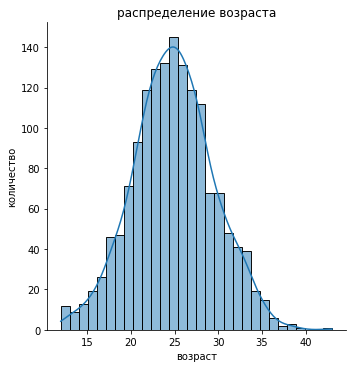

In [15]:
plt.figure(figsize=(100, 8))
sns.displot (users['age'], kde= True )
plt.title("распределение возраста")
plt.xlabel("возраст")
plt.ylabel("количество")
plt.show()

тут все нормально, выбросов нет

<Figure size 7200x576 with 0 Axes>

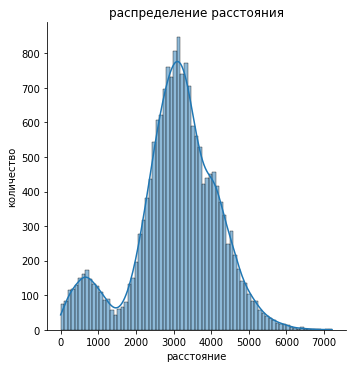

In [16]:
plt.figure(figsize=(100, 8))
sns.displot (rides['distance'], kde= True )
plt.title("распределение расстояния")
plt.xlabel("расстояние")
plt.ylabel("количество")
plt.show()

Тут есть небольшое отклонение от нормальности. Но с точки зрения пользователя сервисом ситуация, когда одни пользователи перемещаются на короткие, а другие на длинные расстояния, не лишина правды.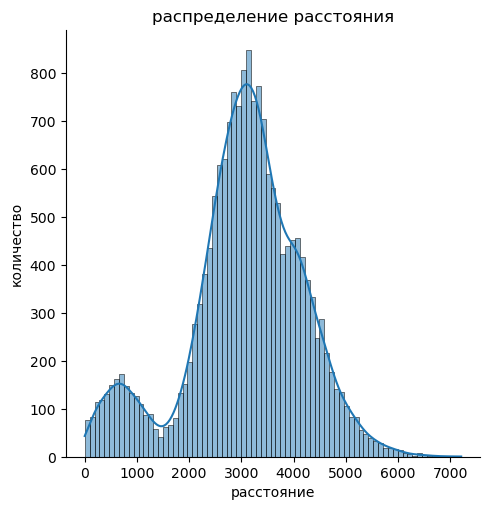

<Figure size 7200x576 with 0 Axes>

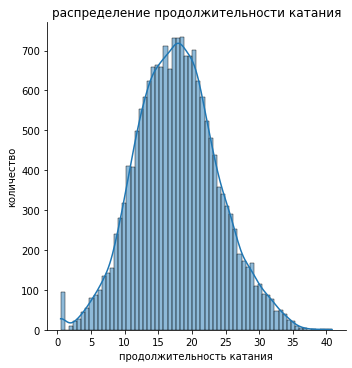

In [17]:

plt.figure(figsize=(100, 8))
sns.displot (rides['duration'], kde= True )
plt.title("распределение продолжительности катания")
plt.xlabel("продолжительность катания")
plt.ylabel("количество")
plt.show()

Есть выброс в самом начале, он не значительный , удалим эти данные из сета

In [18]:
rides=rides.loc[rides['duration']>1]

Не согласен, т.к. в дальнейшем мы изчаем зависимость продолжительности катания и эти данные могут внести ошибку в расчет среднего значения. А т.к. они не многочисленные, то их отсутствие в расчете не сильно скажется в расчете рентабельности.

Выводы по разделу:
Выбросов в данных не много, дубликатов тоже не много, всё провернео и удалено. По типу данных дата приведена к типу datetime, остальные изначально правильные.

---------------------------------------------------------------------------------------------------------------------------

# Исследовательский анализ данных

# Частота встречаемости городов

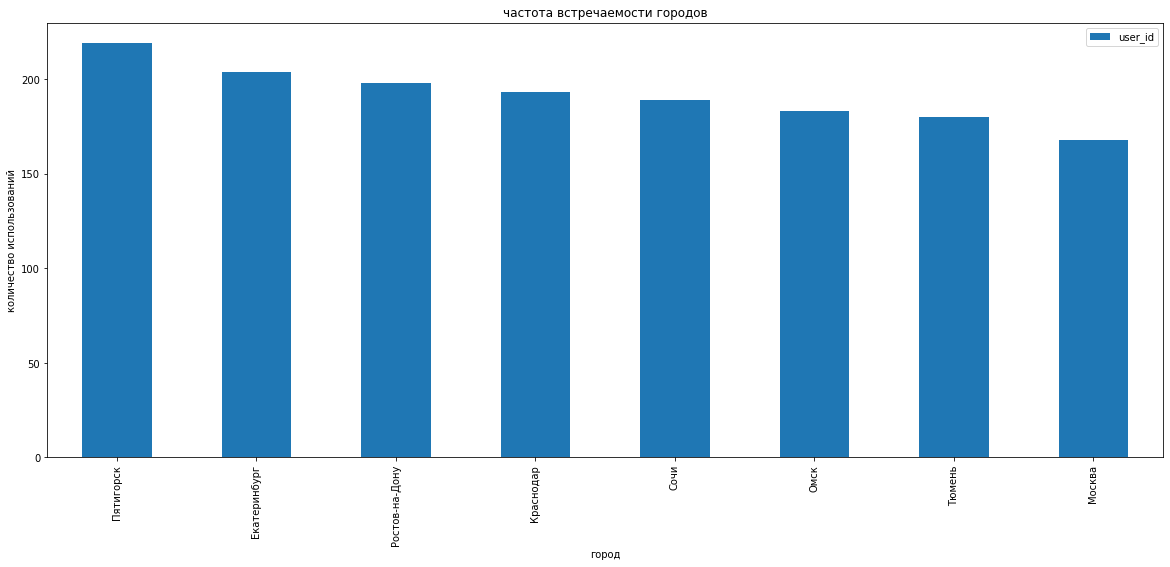

,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189


In [19]:
pivot = users.pivot_table(index=['city'], values=['user_id'], aggfunc='count').sort_values(by=['user_id'], ascending=False)
pivot.plot(y = 'user_id', kind='bar', figsize=(20, 8))
plt.xticks(rotation=90)
plt.title("частота встречаемости городов")
plt.xlabel("город")
plt.ylabel("количество использований")
plt.show()
pivot.head()

Очень интерессная картина, тройку городов состоит из Пятигорска, Екатеринбурга и Ростова-на-дону.

# Cоотношение пользователей с подпиской и без подписки

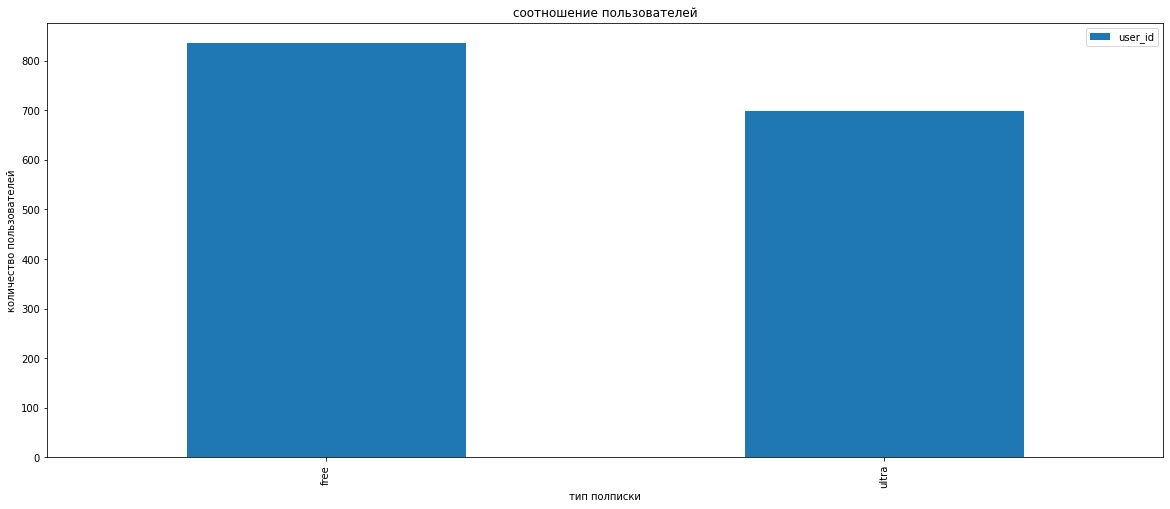

In [20]:
pivot = users.pivot_table(index=['subscription_type'], values=['user_id'], aggfunc='count').sort_values(by=['user_id'], ascending=False)
pivot.plot(y = 'user_id', kind='bar', figsize=(20, 8))
plt.xticks(rotation=90)
plt.title("соотношение пользователей")
plt.xlabel("тип полписки")
plt.ylabel("количество пользователей")
plt.show()

Больше всего "бесплатных" пользователей.

In [21]:
pivot

,user_id
subscription_type,
free,835
ultra,699


In [22]:
#Рассчитаем долю каждой группы
pivot['share']=(pivot['user_id']/pivot['user_id'].sum())*100
pivot

,user_id,share
subscription_type,,
free,835,54.432855
ultra,699,45.567145


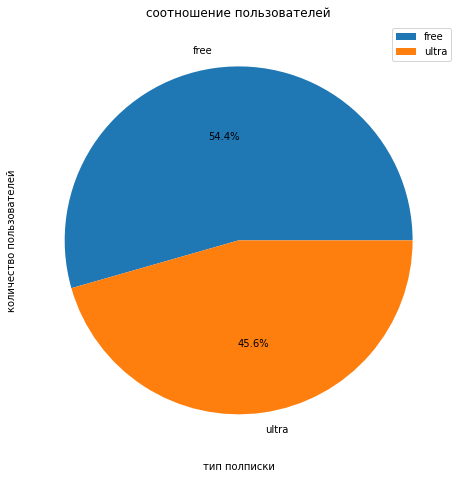

In [23]:

pivot.plot(y = 'share', kind='pie', figsize=(20, 8), autopct='%1.1f%%')
plt.xticks(rotation=90)
plt.title("соотношение пользователей")
plt.xlabel("тип полписки")
plt.ylabel("количество пользователей")
plt.show()

Больше всего free пользователей (54,4%), пользователей ultra меньше (46%)

# возраст пользователей

In [24]:
#разобьем пользователей на группы
def age_group(age):
    if age <= 7:
        return 'ребенок до 7 лет'
    elif 7 < age <= 18:
        return 'подросток 7-18 лет'
    elif 18 < age <= 45:
        return 'средний 18-45 лет'
    elif 45 < age <= 60:
        return 'предпенсионный 45-60 лет'
    elif age > 60:
        return 'пенсионер 60 и более'

users['age_group'] = users['age'].apply(lambda x: age_group(x))
grouped_data = users.groupby('age_group')['user_id'].count()

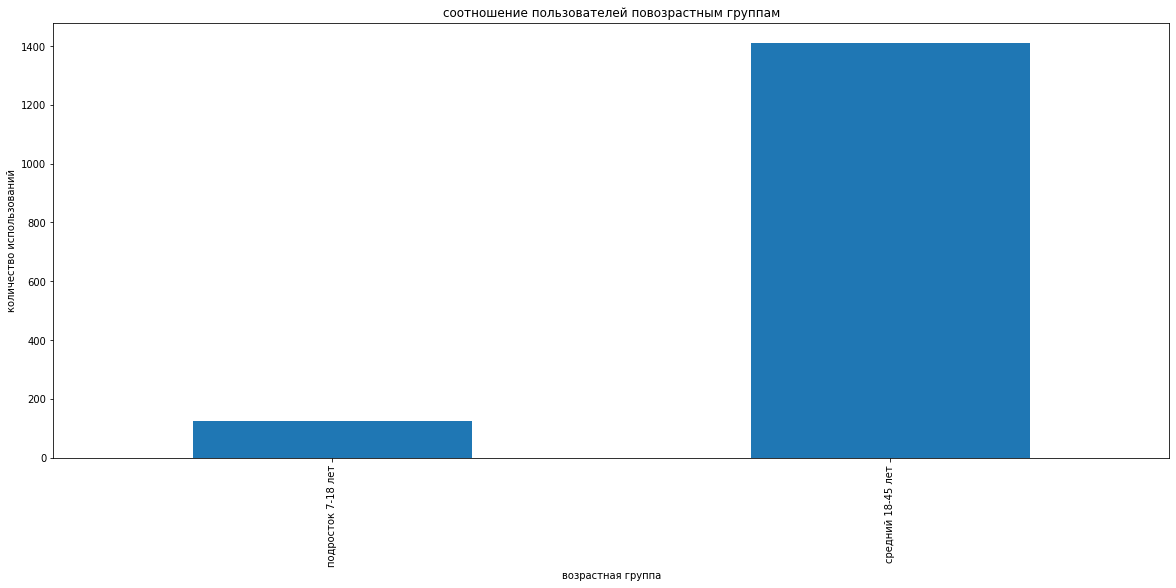

In [25]:
grouped_data.plot(y = 'user_id', kind='bar', figsize=(20, 8))
plt.xticks(rotation=90)
plt.title("соотношение пользователей повозрастным группам")
plt.xlabel("возрастная группа")
plt.ylabel("количество использований")
plt.show()

Больше всего катаются люди среднего возраста 18-45 лет.

<Figure size 7200x576 with 0 Axes>

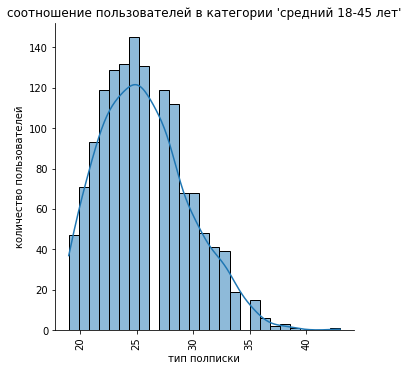

In [26]:
grouped_data1 = users[users['age_group'] == 'средний 18-45 лет']

plt.figure(figsize=(100, 8))
sns.displot (grouped_data1['age'], kde= True )
plt.xticks(rotation=90)
plt.title("соотношение пользователей в категории 'средний 18-45 лет'")
plt.xlabel("тип полписки")
plt.ylabel("количество пользователей")
plt.show()


Больше всего катающихся в возрасте 24-26 лет

<div class="alert alert-warning">
<b>⚠️ Комментарий ревьюера v1:</b> 
<br>В данном случае после графика ещё можно использовать метод describe() для этого столбца. Так мы сможем увидеть расчет описательных статистик
</div>

# расстояние и длительность одной поездки

In [27]:
# каждое значение из столбца duration округляется с помощью «потолка»: 
rides['duration'] = np.ceil(rides['duration'])
rides['duration'].describe()

count    17973.000000
mean        18.394981
std          5.979419
min          3.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

<Figure size 7200x576 with 0 Axes>

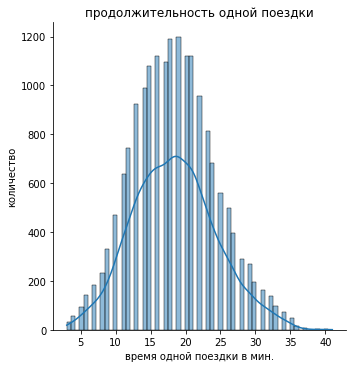

In [28]:
plt.figure(figsize=(100, 8))
sns.displot (rides['duration'], kde= True )
plt.title("продолжительность одной поездки")
plt.xlabel("время одной поездки в мин.")
plt.ylabel("количество")
plt.show()

В среднем пользователи катаются 18-19 мин

<Figure size 7200x576 with 0 Axes>

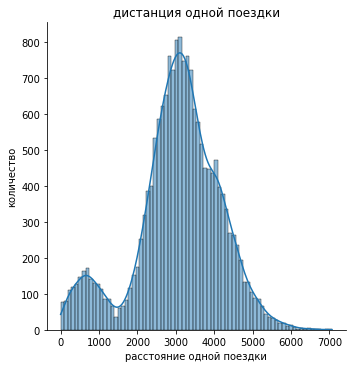

In [29]:
plt.figure(figsize=(100, 8))
sns.displot (rides['distance'], kde= True )
plt.title("дистанция одной поездки")
plt.xlabel("расстояние одной поездки")
plt.ylabel("количество")
plt.show()

In [30]:
rides['distance'].describe()

count    17973.000000
mean      3059.863833
std       1108.814612
min          0.855683
25%       2538.839628
50%       3129.029255
75%       3762.636244
max       7066.003772
Name: distance, dtype: float64

В среднем преодолевают 3060 метров за одну поездку

---------------------------------------------------------------------------------------------------------------------------

# Объединение данных

Для проведения дальнейшего анализа объединим данные.

In [31]:
df=users.merge(rides)
df=df.merge(subscriptions)
df.head()

,user_id,name,age,city,subscription_type,age_group,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,средний 18-45 лет,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,средний 18-45 лет,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,средний 18-45 лет,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,средний 18-45 лет,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,средний 18-45 лет,4028.687306,27.0,2021-08-28,8,6,0,199


<div class="alert alert-warning">
<b>⚠️ Комментарий ревьюера v1:</b> 
<br>Не забывай проверять размерность таблиц после любых операций с ними (создание, срезы, объединение). Это позволить понять, ничего ли не потерялось при объединении
</div>

In [32]:
free = df[df['subscription_type'] == 'free']
free.head()

,user_id,name,age,city,subscription_type,age_group,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,средний 18-45 лет,2515.690719,15.0,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,средний 18-45 лет,846.932642,17.0,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,средний 18-45 лет,4004.434142,21.0,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,средний 18-45 лет,1205.911290,10.0,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,средний 18-45 лет,3047.379435,18.0,2021-02-14,2,8,50,0


In [33]:
free['distance'].describe()

count    11473.000000
mean      3028.374239
std       1235.541051
min          0.855683
25%       2360.878149
50%       3102.083025
75%       3883.979311
max       7066.003772
Name: distance, dtype: float64

<Figure size 7200x576 with 0 Axes>

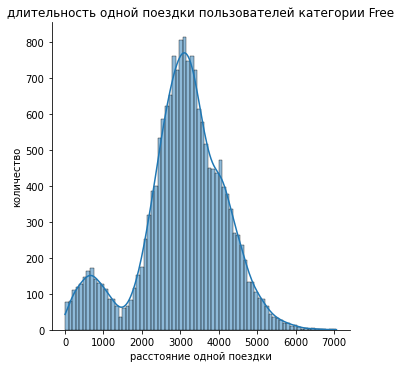

In [34]:
plt.figure(figsize=(100, 8))
sns.displot (df['distance'], kde= True )
plt.title("длительность одной поездки пользователей категории Free")
plt.xlabel("расстояние одной поездки")
plt.ylabel("количество")
plt.show()

Средний пробег пользователей в категории free составляет 3028 км

<Figure size 7200x576 with 0 Axes>

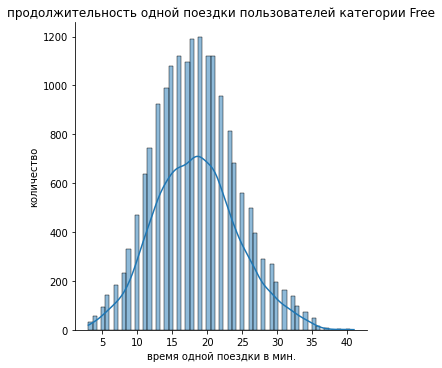

In [35]:
plt.figure(figsize=(100, 8))
sns.displot (df['duration'], kde= True )
plt.title("продолжительность одной поездки пользователей категории Free")
plt.xlabel("время одной поездки в мин.")
plt.ylabel("количество")
plt.show()

In [36]:
free['duration'].describe()

count    11473.000000
mean        18.030855
std          6.166175
min          3.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

Среднее время одной поездки в категории free 18 мин.

In [37]:
ultra = df[df['subscription_type'] == 'ultra']
ultra.head()

,user_id,name,age,city,subscription_type,age_group,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,средний 18-45 лет,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,средний 18-45 лет,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,средний 18-45 лет,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,средний 18-45 лет,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,средний 18-45 лет,4028.687306,27.0,2021-08-28,8,6,0,199


In [38]:
ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

<Figure size 7200x576 with 0 Axes>

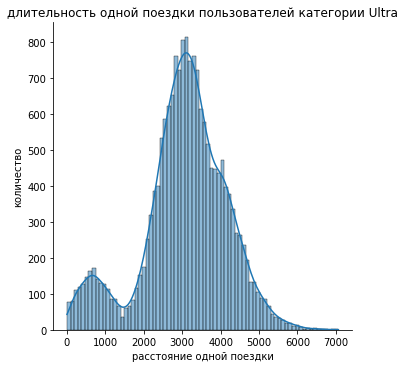

In [39]:
plt.figure(figsize=(100, 8))
sns.displot (df['distance'], kde= True )
plt.title("длительность одной поездки пользователей категории Ultra")
plt.xlabel("расстояние одной поездки")
plt.ylabel("количество")
plt.show()

средняя дистанция одной поездки в категории ultra составляет 3115 км.

In [40]:
ultra['duration'].describe()

count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64

<Figure size 7200x576 with 0 Axes>

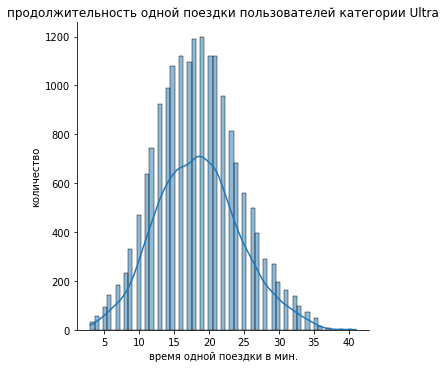

In [41]:
plt.figure(figsize=(100, 8))
sns.displot (df['duration'], kde= True )
plt.title("продолжительность одной поездки пользователей категории Ultra")
plt.xlabel("время одной поездки в мин.")
plt.ylabel("количество")
plt.show()

средняя продолжительность одной поездки пользователей категории Ultra составляет 19 мин.

---------------------------------------------------------------------------------------------------------------------------

# Подсчёт выручки

In [42]:
df_new = df.groupby(['user_id', 'month']).agg({
    'distance': 'sum',
    'duration': 'sum',
    'name': 'count'
}).reset_index()

# Переименование столбцов для ясности
df_new.columns = ['user_id', 'month', 'total_distance', 'total_duration', 'trip_count']

# Вывод агрегированного датафрейма
print(df_new)

       user_id  month  total_distance  total_duration  trip_count
0            1      1     7027.511294            42.0           2
1            1      4      754.159807             7.0           1
2            1      8     6723.470560            46.0           2
3            1     10     5809.911100            32.0           2
4            1     11     7003.499363            56.0           3
...        ...    ...             ...             ...         ...
11295     1534      6     3409.468534            26.0           2
11296     1534      8     7622.453034            48.0           2
11297     1534      9     4928.173852            23.0           1
11298     1534     11    13350.015305            78.0           4
11299     1534     12     2371.711192            16.0           1

[11300 rows x 5 columns]


In [43]:
rides['duration'] = np.ceil(rides['duration']) 
df_new = df.groupby(['user_id', 'month', 'subscription_type', 'start_ride_price', 'minute_price', 'subscription_fee']).agg({
    'distance': 'sum',
    'duration': 'sum',
    'name': 'count'
}).reset_index()

# Переименование столбцов для ясности
df_new.columns = ['user_id', 'month', 'subscription_type', 'start_ride_price','minute_price', 'subscription_fee', 'total_distance', 'total_duration', 'trip_count']

df_new['revenue']=df_new['start_ride_price']*df_new['trip_count']+df_new['minute_price']*df_new['total_duration']+df_new['subscription_fee']
df_new = df_new[['user_id', 'month', 'subscription_type', 'total_distance', 'total_duration', 'trip_count', 'revenue']]

df_new


,user_id,month,subscription_type,total_distance,total_duration,trip_count,revenue
0,1,1,ultra,7027.511294,42.0,2,451.0
1,1,4,ultra,754.159807,7.0,1,241.0
2,1,8,ultra,6723.470560,46.0,2,475.0
3,1,10,ultra,5809.911100,32.0,2,391.0
4,1,11,ultra,7003.499363,56.0,3,535.0
...,...,...,...,...,...,...,...
11295,1534,6,free,3409.468534,26.0,2,308.0
11296,1534,8,free,7622.453034,48.0,2,484.0
11297,1534,9,free,4928.173852,23.0,1,234.0
11298,1534,11,free,13350.015305,78.0,4,824.0


---------------------------------------------------------------------------------------------------------------------------

# Проверка гипотиз

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. 

Нулевая гипотеза: Среднее время на поездку пользователей с подпиской равно среднему времени на поездку пользователей без подписки. Альтернативная: Среднее время на поездку пользователей с подпиской не равно среднему времени на поездку пользователей без подписки.

In [44]:
subscribed_users = df[df['subscription_type'] == 'ultra']['duration']
non_subscribed_users = df[df['subscription_type'] == 'free']['duration']

# Проведение t-теста
t_statistic, p_value = ttest_ind(subscribed_users, non_subscribed_users, equal_var=False, alternative='greater')

# Печать результатов
print(f"T-статистика: {t_statistic}")
print(f"P-значение: {p_value}")

# Проверка статистической значимости
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: существует статистически значимая разница в продолжительности поездок.")
else:
    print("Нет достаточных доказательств для отвержения нулевой гипотезы.")

T-статистика: 11.18719386710581
P-значение: 3.086332092684639e-29
Отвергаем нулевую гипотезу: существует статистически значимая разница в продолжительности поездок.


Гипотеза о том что пользователи с подпиской тратят больше времени на поездки не подтвердилась. Также можно сказать, что пользователи с подпиской не выгодны компании. Пользователи с подпиской - точка роста для данной компании.

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

Нулевая гипотеза - среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров. Альтернативная - среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не равно 3130 метров.

In [45]:
# Выборка расстояний для пользователей с подпиской
subscribed_distances = df[df['subscription_type'] == 'ultra']['distance']


# Проведение одновыборочного t-теста
t_statistic, p_value = ttest_1samp(subscribed_distances, 3130, alternative = 'greater')

# Печать результатов
print(f"T-статистика: {t_statistic}")
print(f"P-значение: {p_value}")

# Проверка статистической значимости
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: среднее расстояние для пользователей с подпиской за одну поездку менее 3130 метров.")
else:
    print("Нет достаточных доказательств для отвержения нулевой гипотезы.")

T-статистика: -1.402123166869486
P-значение: 0.9195368847849785
Нет достаточных доказательств для отвержения нулевой гипотезы.


Гипотеза о том, что среднее расстояние для пользователей с подпиской за одну поездку не превышает 3130 метров подтвердилась.

Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Нулевая Гипотеза - помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки. Альтернативная - помесячная выручка от пользователей с подпиской по месяцам не равна выручке от пользователей без подписки

In [46]:
subscribed_users = df_new[df_new['subscription_type'] == 'ultra']['revenue']
non_subscribed_users = df_new[df_new['subscription_type'] == 'free']['revenue']

# Проведение t-теста
t_statistic, p_value = ttest_ind(subscribed_users, non_subscribed_users, equal_var=False, alternative='greater')

# Печать результатов
print(f"T-статистика: {t_statistic}")
print(f"P-значение: {p_value}")

# Проверка статистической значимости
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Статистически значимое различие в выручке от пользователей с подпиской и без подписки.")
else:
    print("Нет достаточных доказательств для отвержения нулевой гипотезы.")

T-статистика: 12.943973883454
P-значение: 2.4970242872858465e-38
Отвергаем нулевую гипотезу. Статистически значимое различие в выручке от пользователей с подпиской и без подписки.


Гипотеза не подтвердилась, пользователи с подпиской приносят меньше выручки чем пользователи без подписки.

Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Мы имеем одну генеральную совокупность, с которой произошли некоторые изменения. В этом случае мы будем проверять, равны ли средние совокупности до и после этого изменения. Выборки в этом случае будут зависимыми, иначе — парными.
Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок в Python, применим метод scipy.stats.ttest_rel().

________________________________________________________________________________________________________________________

# Распределения

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

In [47]:
# Заданные параметры
p_success = 0.1  # Вероятность успеха (продления подписки)
target_clients = 100  # Минимальное количество клиентов для продления подписки
target_probability = 0.05  # Целевая вероятность P(X < target_clients)

# Функция для поиска минимального количества промокодов
def find_min_promo_codes(p_success, target_clients, target_probability):
    n = 1  # Начинаем с одного промокода

    # Итеративно увеличиваем количество промокодов и проверяем вероятность P(X < target_clients)
    while stats.binom.cdf(target_clients, n, p_success) > target_probability:
        n += 1

    return n

# Находим минимальное количество промокодов
min_promo_codes = find_min_promo_codes(p_success, target_clients, target_probability)

# Выводим результат
print(f"Минимальное количество промокодов: {min_promo_codes}")

Минимальное количество промокодов: 1172


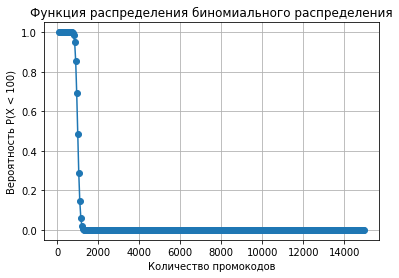

In [48]:
from scipy.stats import binom

# Задаем параметры биномиального распределения
n = np.arange(100, 15000, 50)  # количество промокодов
p = 0.1  # вероятность продления подписки

# Считаем вероятность P(X < 100) для каждого значения n
prob = binom.cdf(99, n, p)

# Строим график
plt.plot(n, prob, marker='o')
plt.xlabel('Количество промокодов')
plt.ylabel('Вероятность P(X < 100)')
plt.title('Функция распределения биномиального распределения')
plt.grid(True)
plt.show()

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:82: RuntimeWarning: divide by zero encountered in _binom_cdf
  return _boost._binom_cdf(k, n, p)


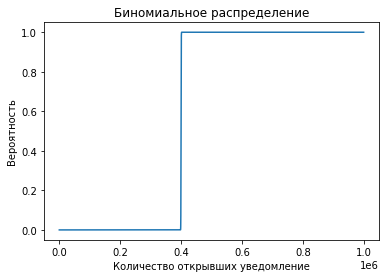

Вероятность того, что уведомление откроют не более 399.5 тыс. пользователей составляет примерно 15.40%


In [49]:
# Задаем параметры распределения
p = 0.4  # Вероятность открытия уведомления
n = 1000000  # Количество уведомлений
x = np.arange(0, n+1)
prob = binom.cdf(x, n, p)


# Строим график функции распределения биномиального распределения
plt.plot(x, prob)
plt.xlabel('Количество открывших уведомление')
plt.ylabel('Вероятность')
plt.title('Биномиальное распределение')
plt.show()

# Оценим вероятность открытия уведомления не более 399.5 тыс. пользователей
prob = binom.cdf(399500, n, p)
print(f"Вероятность того, что уведомление откроют не более 399.5 тыс. пользователей составляет примерно {prob:.2%}")

Выводы по работе:
    Тройка городов состоит из Пятигорска, Екатеринбурга и Ростова-на-дону.
    Больше всего "бесплатных" пользователей.
    Больше всего катаются люди среднего возраста 18-45 лет. Группа 24-26 лет преобладает.
    В среднем пользователи катаются 18-19 мин (в категории free 18 мин, в категории Ultra составляет 19 мин.).  Разница в категориях не большая, порядка 1 мин.
    В среднем преодолевают 3060 метров за одну поездку (в категории free составляет 3028 км, в категории ultra составляет 3115 км.). По категориям разница не большая, порядка 13 км,  причем пользователи с подпиской проезжают меньшее расстояние.
    Гипотеза о том что пользователи с подпиской тратят больше времени на поездки не подтвердилась. Пользователи с подпиской не выгодны компании
    Гипотеза о том, что среднее расстояние для пользователей с подпиской за одну поездку не превышает 3130 метров подтвердилась.
    Гипотеза о том, что пользователи с подпиской приносят больше выручки не подтвердилась, пользователи с подпиской приносят меньше выручки чем пользователи без подписки.
    
    Точка роста для компании - пользователи с подпиской, нужно каким-то образом увеличить время пользования самокатом, например сделать функцию ожидания, или придумать иное.
